# Model Building Linear with Transformation

Build linear regression model for Domestic office deposits_Avg_growth_ratio.

In [331]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.special import expit, logit
y = 'Noninterest-bearing deposits_Avg_growth_ratio'
col_deposits = ['Domestic office deposits', 
                'Interest-bearing deposits', 
                'Noninterest-bearing deposits', 
                'Time deposits']

## Data Preparation

### Split Train and OOT Data

- Last 6 timekeys for OOT, rest for train.
- Due to the limited samples, all non-OOT data are used for fitting model.

In [332]:
df = pd.read_csv('data/full_modeling.csv').sort_values('timekey').reset_index(drop=True)
df = df[~df[y].isnull()] 

# Generate full feature list
targets = [col for col in df.columns if 'deposits' in col]
cols_X = df.columns
for target in col_deposits + ['timekey']:
    cols_X = [col for col in cols_X if target not in col]

oot_data = df.tail(6)
train_data = df.iloc[:-6]

X_oot, y_oot = oot_data[cols_X], oot_data[y]
X_train, y_train = train_data[cols_X], train_data[y]

### Target Transformation

Define target tranformation

$$
y_{new} = f(y) = \frac{\exp(a(y-1))}{\exp(a(y-1))+1}
$$

- Keep the transformation for the center data linear.
- Bound outliers

In [333]:
a = 0.5
b = 1000
err = 0.000000001
def f(x):
    return b*expit((x - 1) * a)

def f_inv(x):
    return logit(np.clip(x/b, err, 1 - err)) / a + 1

y_train = y_train.apply(f)

### Feature Processing

In [334]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=cols_X, index=X_train.index)

X_oot_processed = preprocessor.transform(X_oot)  # Use transform, not fit_transform
X_oot_processed = pd.DataFrame(X_oot_processed, columns=cols_X, index=X_oot.index)

## Fit Model

### Feature selection with LASSO

- Linear regression with L1 regularization to force coefficients to zeros.

In [335]:
lasso_model = Lasso(
   # alpha=0.0015,
    alpha=1.5,
    max_iter=100000,
    tol=1e-3,
    random_state=42
)

lasso_model.fit(X_train_processed, y_train)

coefficients = pd.DataFrame({
    'Feature': cols_X,
    'Coefficient': lasso_model.coef_.ravel()
}).sort_values('Coefficient', ascending=False, key=abs).reset_index(drop=True)
coefficients = coefficients[coefficients['Coefficient']!=0]
print(coefficients)

              Feature  Coefficient
0      FED_FUNDS_ROC4    -0.914386
1              M2_QOQ     0.619336
2     LABOR_FORCE_YOY    -0.232256
3  YIELD_CURVE_30Y10Y     0.056748
4         TREASURY_2Y    -0.020746


### Linear regression with selected features

In [341]:
# Use cols_X_short (short list of features)
cols_X_short = coefficients['Feature'].tolist()
cols_X_short = [col for col in cols_X_short if col not in ['FED_FUNDS_ROC4']]
X_train_processed_short = X_train_processed[cols_X_short]

# Fit Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_processed_short, y_train)

# Extract coefficients
all_params = np.concatenate([linear_model.coef_.ravel(), [linear_model.intercept_]])
coef_df = pd.DataFrame({
    "feature": cols_X_short + ['intercept'],
    "coefficient": all_params
})
print(f"Linear Model Coefficients:\n\n{coef_df}")

r2_train = linear_model.score(X_train_processed_short, y_train)
print(f"Training Rsq: {r2_train:.4f}")

# OOT does not have enough sample for Rsq calculation

Linear Model Coefficients:

              feature  coefficient
0              M2_QOQ     1.887977
1     LABOR_FORCE_YOY    -0.901459
2  YIELD_CURVE_30Y10Y     1.010952
3         TREASURY_2Y    -0.376962
4           intercept   502.241837
Training Rsq: 0.5353


## Model performance

### Multi-Colinearity check

In [337]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif = calculate_vif(X_train_processed_short)
print(f"Variance Inflation Factor:\n{vif}")

Variance Inflation Factor:
              Feature       VIF
3         TREASURY_2Y  3.733060
2  YIELD_CURVE_30Y10Y  3.283758
1     LABOR_FORCE_YOY  1.772359
0              M2_QOQ  1.376418


### Mean absolute error

In [338]:
# Train predictions
y_pred_train = linear_model.predict(X_train_processed_short)
valid_train = pd.DataFrame({'y_pred': y_pred_train, 'y_actual': y_train})
# Apply inverse transformation for measuring MAE
valid_train=valid_train.apply(f_inv)

# OOT predictions
y_pred_oot = linear_model.predict(X_oot_processed[cols_X_short])
valid_oot = pd.DataFrame({'y_pred': y_pred_oot, 'y_actual': y_oot})
# Apply inverse transformation for measuring MAE
valid_oot['y_pred']=valid_oot['y_pred'].apply(f_inv)

# Calculate MAE
mae = {}
mae['train'] = np.mean(np.abs(valid_train['y_actual'] - valid_train['y_pred']))
mae['oot'] = np.mean(np.abs(valid_oot['y_actual'] - valid_oot['y_pred']))
print(f'\nModel performance\n{mae}')


Model performance
{'train': 0.016538106693594058, 'oot': 0.0054623863577550336}


### Backtesting

- Calculate deposits from predicted growth

In [339]:
from utils import plot_bt,timekey_to_quarter

deposits_col = y[:-13]
pred_col = deposits_col + '_pred'

bt = df.tail(6+1)[['timekey', deposits_col, y]]
bt[pred_col] = np.nan

# First segment: t=0 to t+4
bt.loc[bt.index[0], pred_col] = bt.loc[bt.index[0], deposits_col]
starting_value = bt[pred_col].iloc[0]
predicted_growth_ratios = valid_oot['y_pred'].values  # Changed from y_pred_scaled

bt.loc[bt.index[1:5], pred_col] = starting_value * np.cumprod(predicted_growth_ratios[:4])

# t+5: Start from actual value at t+1 (index 1)
starting_value_2 = bt.loc[bt.index[1], deposits_col]
bt.loc[bt.index[5], pred_col] = starting_value_2 * np.prod(predicted_growth_ratios[1:5])

# t+6: Start from actual value at t+2 (index 2)
starting_value_3 = bt.loc[bt.index[2], deposits_col]
bt.loc[bt.index[6], pred_col] = starting_value_3 * np.prod(predicted_growth_ratios[2:6])

bt['quarter'] = bt['timekey'].apply(lambda x: timekey_to_quarter(x))

- Plot backtesting

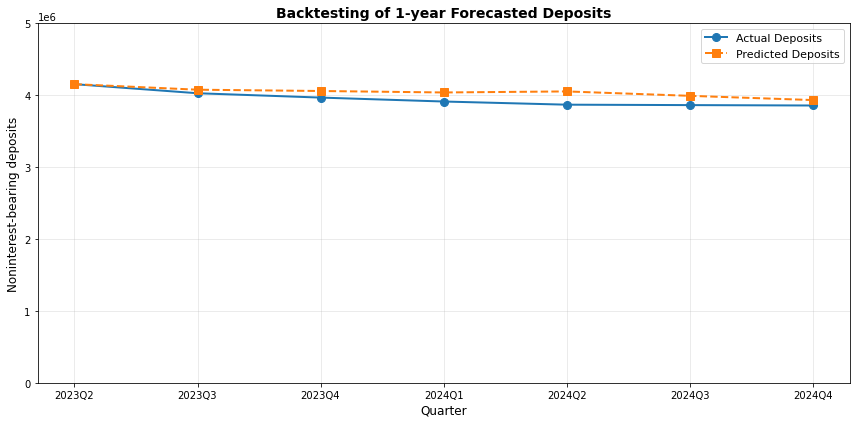


Backtesting Results ($MM):
   quarter  Noninterest-bearing deposits_Avg  \
78  2023Q2                             4.155   
79  2023Q3                             4.028   
80  2023Q4                             3.968   
81  2024Q1                             3.913   
82  2024Q2                             3.869   
83  2024Q3                             3.863   
84  2024Q4                             3.858   

    Noninterest-bearing deposits_Avg_pred  
78                                  4.155  
79                                  4.078  
80                                  4.060  
81                                  4.039  
82                                  4.054  
83                                  3.992  
84                                  3.933  


In [340]:
import matplotlib.pyplot as plt
from utils import timekey_to_quarter

def plot_bt(bt, deposits_col, pred_col,ylabel= 'Noninterest-bearing deposits',
            title='Backtesting of 1-year Forecasted Deposits'):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(bt['quarter'], bt[deposits_col], 
            marker='o', linewidth=2, markersize=8, label='Actual Deposits')
    ax.plot(bt['quarter'], bt[pred_col], 
            marker='s', linewidth=2, markersize=8, linestyle='--', label='Predicted Deposits')
    
    ax.set_ylim(bottom=0_000_000, top=5_000_000)
    ax.set_xlabel('Quarter', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    
    return fig
fig = plot_bt(bt, deposits_col, pred_col,ylabel= 'Noninterest-bearing deposits')
plt.savefig('figures/bt_NIB.png', dpi=600, bbox_inches='tight')
plt.show()

print("\nBacktesting Results ($MM):")
bt = bt.applymap(lambda x: round(x/1000000,3) if not isinstance(x,str) else x)
print(bt[['quarter', deposits_col, pred_col]])